In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

sns.set(style='white', context='notebook', palette='deep')

/Users/Bakaj/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
#load datasets
train_df = pd.read_csv(r'Datasets/mnist_train.csv')
test_df = pd.read_csv(r'Datasets/mnist_test.csv')

In [4]:
# split the training and testing data 
# into X (image) and Y (label)
x_train = train_df.iloc[:, 1:]
y_train = train_df.iloc[:, 0]

x_test = test_df.iloc[:, 1:]
y_test = test_df.iloc[:, 0]

In [5]:
#normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

In [6]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
x_train = x_train.values.reshape(-1,28,28,1)
x_test = x_test.values.reshape(-1,28,28,1)

In [7]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
y_train = to_categorical(y_train, num_classes = 10)
y_test = to_categorical(y_test, num_classes = 10)

In [8]:
# split the training data into train and validate arrays
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [9]:
model = Sequential([
    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)),
    Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'),
    MaxPool2D(pool_size=(2,2)),
    Dropout(0.25),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'),
    MaxPool2D(pool_size=(2,2), strides=(2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(256, activation = "relu"),
    Dropout(0.5),
    Dense(10, activation = "softmax")
])

In [ ]:
model.summary()

In [10]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [11]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [37]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

epochs = 11
batch_size = 512

In [25]:
# With data augmentation to prevent overfitting

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [39]:
# Fit the model
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/11
93/93 [==============================] - 328s 4s/step - loss: 0.0359 - acc: 0.9896 - val_loss: 0.0208 - val_acc: 0.9943
Epoch 2/11
93/93 [==============================] - 340s 4s/step - loss: 0.0359 - acc: 0.9894 - val_loss: 0.0225 - val_acc: 0.9931
Epoch 3/11
93/93 [==============================] - 300s 3s/step - loss: 0.0335 - acc: 0.9902 - val_loss: 0.0209 - val_acc: 0.9939
Epoch 4/11
93/93 [==============================] - 290s 3s/step - loss: 0.0317 - acc: 0.9911 - val_loss: 0.0208 - val_acc: 0.9948
Epoch 5/11
93/93 [==============================] - 328s 4s/step - loss: 0.0318 - acc: 0.9905 - val_loss: 0.0201 - val_acc: 0.9943
Epoch 6/11
93/93 [==============================] - 291s 3s/step - loss: 0.0308 - acc: 0.9911 - val_loss: 0.0228 - val_acc: 0.9935
Epoch 7/11
93/93 [==============================] - 290s 3s/step - loss: 0.0297 - acc: 0.9913 - val_loss: 0.0198 - val_acc: 0.9950
Epoch 8/11
93/93 [==============================] - 291s 3s/step - loss: 0.0298 - a

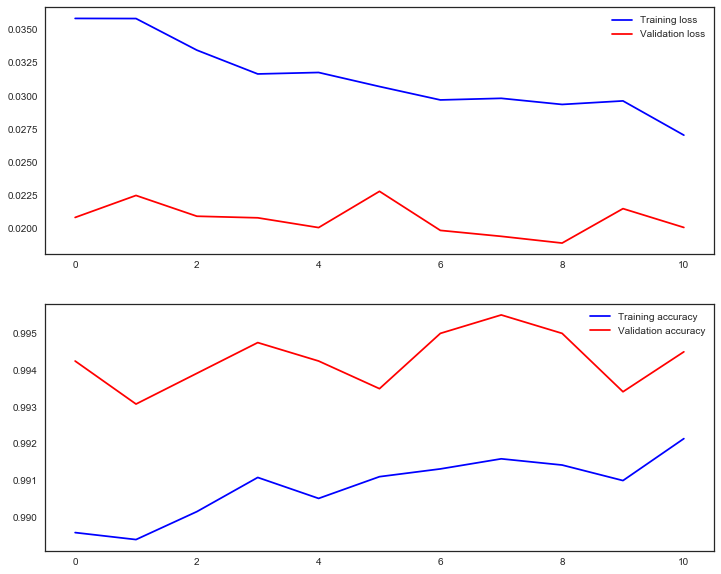

In [59]:
fig, ax = plt.subplots(2, figsize=(12, 10))


ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [42]:
final_loss, final_acc = model.evaluate(x_validate, y_validate, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0201, final accuracy: 0.9945


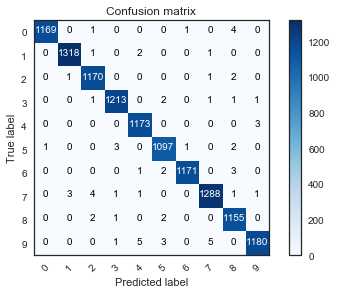

In [58]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_prediction = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_prediction,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

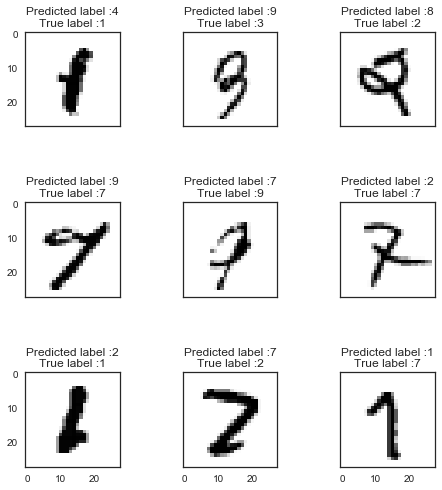

In [66]:
# Display some error results 
# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_prediction[errors]
y_true_errors = y_true[errors]
x_val_errors = x_validate[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows X images with their predicted and real labels"""
    n = 0
    nrows = 3
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True, figsize=(8, 8))
    plt.subplots_adjust(hspace=0.8)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap='binary')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top X errors 
most_important_errors = sorted_dela_errors[9:]

# Show the top 6 errors
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)